# Data loading

In [45]:
import time
import numpy as np
import pandas as pd

!pip install -U scikit-learn
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Load data set
loan_test_dataset = pd.read_csv('/content/loan_test.csv')
loan_train_dataset = pd.read_csv('/content/loan_train.csv')
print("\nIntial shape of train and test data: ", loan_train_dataset.shape, loan_test_dataset.shape)
print("\nColumns initially: ", list(loan_test_dataset.columns.values))

# Remove rows having loan_status = "Current"
loan_train_dataset = loan_train_dataset.drop(loan_train_dataset[loan_train_dataset.loan_status == "Current"].index)
loan_test_dataset = loan_test_dataset.drop(loan_test_dataset[loan_test_dataset.loan_status == "Current"].index)
print("\nPossible values of loan_status column: ", set(loan_train_dataset["loan_status"]), set(loan_test_dataset["loan_status"]))

# Assign +1 for "Fully Paid" and -1 for "Charged Off" in loan_status column
loan_train_dataset["loan_status"] = loan_train_dataset["loan_status"].map({"Fully Paid": 1, "Charged Off": -1})
loan_test_dataset["loan_status"] = loan_test_dataset["loan_status"].map({"Fully Paid": 1, "Charged Off": -1})
print("\nPossible values of loan_status column now: ", set(loan_train_dataset["loan_status"]), set(loan_test_dataset["loan_status"]))

print("\n", loan_train_dataset)
print("\n", loan_test_dataset)


Intial shape of train and test data:  (24999, 111) (14718, 111)

Columns initially:  ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq

# Data pre-processing

## Handling missing values

In [46]:
# Number of missing values in each column of training data
missing_val_count_by_column = (loan_train_dataset.isnull().sum())
columns_with_large_no_of_missing_values = missing_val_count_by_column[missing_val_count_by_column > 15000].index
print("\nNo of columns having more than 15000 Null values in training dataset: ", len(columns_with_large_no_of_missing_values))

# Drop the columns having more than 15000 NULL values
loan_train_dataset = loan_train_dataset.drop(columns_with_large_no_of_missing_values, axis=1)
loan_test_dataset = loan_test_dataset.drop(columns_with_large_no_of_missing_values, axis=1)

print("\nAfter removing columns having more than 15000 NULL values : ", loan_train_dataset.shape, loan_test_dataset.shape)

# Dropping "emp_title", "desc" column as it has some missing value and it's irrelivent for prediction
loan_train_dataset = loan_train_dataset.drop(["emp_title", "desc"], axis=1)
loan_test_dataset = loan_test_dataset.drop(["emp_title", "desc"], axis=1)

# For rest of the columns which have missing values, are mostly less than 1% of data, so removing those rows
missing_val_count_by_column = (loan_train_dataset.isnull().sum())
loan_train_dataset = loan_train_dataset.dropna(axis=0, subset = missing_val_count_by_column[missing_val_count_by_column > 0].index)
missing_val_count_by_column = (loan_test_dataset.isnull().sum())
loan_test_dataset = loan_test_dataset.dropna(axis=0, subset = missing_val_count_by_column[missing_val_count_by_column > 0].index)

print("\nFinal shape for training and test data after handling missing values: ", loan_train_dataset.shape, loan_test_dataset.shape)



No of columns having more than 15000 Null values in training dataset:  57

After removing columns having more than 15000 NULL values :  (24301, 54) (14276, 54)

Final shape for training and test data after handling missing values:  (23763, 52) (12962, 52)


In [47]:
print("========================================")
total_num = loan_train_dataset.isnull().sum().sort_values(ascending=False)
perc = loan_train_dataset.isnull().sum()/loan_train_dataset.isnull().count() *100

# Creating a data frame:
df_miss = pd.concat([total_num, perc], axis =1 , keys =["Total Missing Values", "Percentage %"]).sort_values(by ="Percentage %", ascending = False)
print(df_miss[df_miss["Percentage %"]>0])

print("========================================")
total_num = loan_test_dataset.isnull().sum().sort_values(ascending=False)
perc = loan_test_dataset.isnull().sum()/loan_test_dataset.isnull().count() *100
# Creating a data frame:
df_miss = pd.concat([total_num, perc], axis =1 , keys =["Total Missing Values", "Percentage %"]).sort_values(by ="Percentage %", ascending = False)
print(df_miss[df_miss["Percentage %"]>0])

print("========================================")
print(loan_train_dataset['pub_rec_bankruptcies'].value_counts())

Empty DataFrame
Columns: [Total Missing Values, Percentage %]
Index: []
Empty DataFrame
Columns: [Total Missing Values, Percentage %]
Index: []
0.0    22775
1.0      984
2.0        4
Name: pub_rec_bankruptcies, dtype: int64


## Remove unnecessary attributes

In [48]:
# Not needed: member_id, issue_d(date), pymnt_plan(all "n"), url, earliest_cr_line(date), initial_list_status(all "f"),
# last_pymnt_d(date), last_credit_pull_d(date), application_type(all "INDIVIDUAL"), id, collections_12_mths_ex_med(all "0.0"), 
# policy_code(all "1"), acc_now_delinq(all "0"), chargeoff_within_12_mths(all "0.0"), delinq_amnt(all "0"), tax_liens(all "0.0"),
# out_prncp(all "0.0"), out_prncp_inv(all "0.0")

print(loan_train_dataset.head)
columns_to_be_dropped = ["member_id", "issue_d", "pymnt_plan", "url", "earliest_cr_line", "initial_list_status", "last_pymnt_d",\
                         "last_credit_pull_d", "application_type", "id", "collections_12_mths_ex_med", "policy_code",\
                         "acc_now_delinq", "chargeoff_within_12_mths", "delinq_amnt", "tax_liens", "out_prncp", "out_prncp_inv"]
loan_train_dataset = loan_train_dataset.drop(columns_to_be_dropped, axis = 1)
loan_test_dataset = loan_test_dataset.drop(columns_to_be_dropped, axis = 1)

print("\nShape of training and test data after dropping unnecessary columns: ", loan_train_dataset.shape, loan_test_dataset.shape)
print("\n", loan_train_dataset.head)

<bound method NDFrame.head of            id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  installment grade sub_grade emp_length home_ownership  annual_inc verification_status issue_d  loan_status pymnt_plan                                                url             purpose                         title zip_code addr_state    dti  delinq_2yrs earliest_cr_line  inq_last_6mths  open_acc  pub_rec  revol_bal revol_util  total_acc initial_list_status  out_prncp  out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee last_pymnt_d  last_pymnt_amnt last_credit_pull_d  collections_12_mths_ex_med  policy_code application_type  acc_now_delinq  chargeoff_within_12_mths  delinq_amnt  pub_rec_bankruptcies  tax_liens
0      573354     737474      10000        10000       9950.00000   36 months    7.51%       311.11     A        A4  10+ years           RENT     30000.0     Source Verified  10

## Encode categorical and ordinal columns

In [49]:
# Need encoding: grade, sub_grade, home_ownership, verification_status, purpose, title, zip_code, addr_state, application_type  

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Apply ordinal encoder for columns: grade, sub_grade, home_ownership, verification_status, title(>12k unique values), 
# zip_code(772 unique values), term, emp_length
ordinal_encoder = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
loan_train_dataset["title"] = loan_train_dataset["title"].str.lower()
ordinal_columns = ["grade", "sub_grade", "home_ownership", "verification_status", "title", "zip_code", "term", "emp_length"]
loan_train_dataset[ordinal_columns] = ordinal_encoder.fit_transform(loan_train_dataset[ordinal_columns])
loan_test_dataset[ordinal_columns] = ordinal_encoder.transform(loan_test_dataset[ordinal_columns])

# Apply one-hot encoder for columns: purpose, addr_state
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
categorical_columns = ["purpose", "addr_state"]
one_hot_columns_train = pd.DataFrame(one_hot_encoder.fit_transform(loan_train_dataset[categorical_columns]))
one_hot_columns_test = pd.DataFrame(one_hot_encoder.transform(loan_test_dataset[categorical_columns]))

# One-hot encoding removes the index so put it back
one_hot_columns_train.index = loan_train_dataset.index
one_hot_columns_test.index = loan_test_dataset.index

# Remove categorical columns (will replace with one-hot encoding)
loan_train_dataset = loan_train_dataset.drop(categorical_columns, axis=1)
loan_test_dataset = loan_test_dataset.drop(categorical_columns, axis=1)

# Add one-hot encoded columns
loan_train_dataset = pd.concat([loan_train_dataset, one_hot_columns_train], axis=1)
loan_test_dataset = pd.concat([loan_test_dataset, one_hot_columns_test], axis=1)

print("\n", loan_train_dataset.head, loan_test_dataset.head)


 <bound method NDFrame.head of        loan_amnt  funded_amnt  funded_amnt_inv  term int_rate  installment  grade  sub_grade  emp_length  home_ownership  annual_inc  verification_status  loan_status   title  zip_code    dti  delinq_2yrs  inq_last_6mths  open_acc  pub_rec  revol_bal revol_util  total_acc   total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee  last_pymnt_amnt  pub_rec_bankruptcies    0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59
0          10000        10000       9950.00000   0.0    7.51%       311.11    0.0        3.0         1.0             3.0     30000.0                  1.0           -1  5437.0      53.0   5.00            0               3        19      

## Additional processing/formatting

In [50]:
# Need processing: int_rate(have %), revol_util(have %)

# Remove % from int_rate
loan_train_dataset['int_rate'] = loan_train_dataset['int_rate'].str.rstrip('%').astype('float')
loan_test_dataset['int_rate'] = loan_test_dataset['int_rate'].str.rstrip('%').astype('float')

# Remove % from revol_util
loan_train_dataset['revol_util'] = loan_train_dataset['revol_util'].str.rstrip('%').astype('float')
loan_test_dataset['revol_util'] = loan_test_dataset['revol_util'].str.rstrip('%').astype('float')

print("\n", loan_train_dataset.head, loan_test_dataset.head)


 <bound method NDFrame.head of        loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  grade  sub_grade  emp_length  home_ownership  annual_inc  verification_status  loan_status   title  zip_code    dti  delinq_2yrs  inq_last_6mths  open_acc  pub_rec  revol_bal  revol_util  total_acc   total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee  last_pymnt_amnt  pub_rec_bankruptcies    0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59
0          10000        10000       9950.00000   0.0      7.51       311.11    0.0        3.0         1.0             3.0     30000.0                  1.0           -1  5437.0      53.0   5.00            0               3        19   

# Gradient boosting classifier

In [121]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Seperate training input and label
y_train = loan_train_dataset["loan_status"]
X_train = loan_train_dataset.drop(["loan_status"], axis = 1)

# Seperate test input and label
y_test = loan_test_dataset["loan_status"]
X_test = loan_test_dataset.drop(["loan_status"], axis = 1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Initialize, train and test the classifier
gradient_boost_classifier = GradientBoostingClassifier(loss = "exponential",
                                                       learning_rate = 0.8,
                                                       n_estimators = 200,
                                                       subsample = 1.0,
                                                       criterion = "friedman_mse",
                                                       min_samples_split = 2,
                                                       min_samples_leaf = 1,
                                                       min_weight_fraction_leaf = 0.0,
                                                       max_depth = 3,
                                                       min_impurity_decrease = 0.0,
                                                       init = None,
                                                       random_state = 42,
                                                       max_features = "auto",
                                                       verbose = 0,
                                                       max_leaf_nodes = None,
                                                       warm_start = False,
                                                       validation_fraction = 0.1,
                                                       n_iter_no_change = None,
                                                       tol = 1e-4,
                                                       ccp_alpha = 0.0)
gradient_boost_classifier.fit(X_train, y_train)
y_pred = gradient_boost_classifier.predict(X_test)
print("\nAccuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

(23763, 91) (12962, 91) (23763,) (12962,)

Accuracy:  0.9981484338836599
Precision:  0.997931282604785
Recall:  0.9999098774333093


# Study the effect of number of estimators


====================== Using numner of trees =  5


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9820243789538652

====================== Using numner of trees =  15


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9932880728282673

====================== Using numner of trees =  25


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9950624903564265

====================== Using numner of trees =  35


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9963740163555007

====================== Using numner of trees =  45


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9968369078845857

====================== Using numner of trees =  55


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9972226508254899

====================== Using numner of trees =  65


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9972226508254899

====================== Using numner of trees =  75


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9973769480018516

====================== Using numner of trees =  85


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9974540965900324

====================== Using numner of trees =  95


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9975312451782132

====================== Using numner of trees =  105


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9975312451782132

====================== Using numner of trees =  115


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.997685542354575

====================== Using numner of trees =  125


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9978398395309366

====================== Using numner of trees =  135


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9978398395309366

====================== Using numner of trees =  145


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9980712852954791

====================== Using numner of trees =  155


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9979169881191174

====================== Using numner of trees =  165


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9979169881191174

====================== Using numner of trees =  175


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9979169881191174

====================== Using numner of trees =  185


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9980712852954791

====================== Using numner of trees =  195


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9980712852954791

====================== Using numner of trees =  205


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9980712852954791

====================== Using numner of trees =  215


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9980712852954791

====================== Using numner of trees =  225


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9981484338836599

====================== Using numner of trees =  235


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9981484338836599

====================== Using numner of trees =  245


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy:  0.9980712852954791


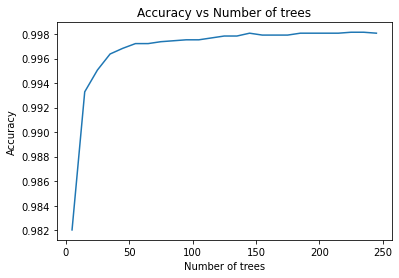

In [109]:
import matplotlib.pyplot as plt

list_of_accuracies, list_of_number_of_trees = [], []
for number_of_trees in range(5, 250, 10):
  print("\n====================== Using numner of trees = ", number_of_trees)
  list_of_number_of_trees.append(number_of_trees)
  
  # Initialize, train and test the classifier
  gradient_boost_classifier = GradientBoostingClassifier(loss = "exponential",
                                                       learning_rate = 0.8,
                                                       n_estimators = number_of_trees,
                                                       subsample = 1.0,
                                                       criterion = "friedman_mse",
                                                       min_samples_split = 2,
                                                       min_samples_leaf = 1,
                                                       min_weight_fraction_leaf = 0.0,
                                                       max_depth = 3,
                                                       min_impurity_decrease = 0.0,
                                                       init = None,
                                                       random_state = 42,
                                                       max_features = "auto",
                                                       verbose = 0,
                                                       max_leaf_nodes = None,
                                                       warm_start = False,
                                                       validation_fraction = 0.1,
                                                       n_iter_no_change = None,
                                                       tol = 1e-4,
                                                       ccp_alpha = 0.0)
  gradient_boost_classifier.fit(X_train, y_train)
  list_of_accuracies.append(gradient_boost_classifier.score(X_test, y_test))
  print("Accuracy: ", list_of_accuracies[-1])

plt.plot(list_of_number_of_trees, list_of_accuracies)
plt.title('Accuracy vs Number of trees')
plt.ylabel('Accuracy')
plt.xlabel('Number of trees')
plt.show()

# Comapare results with a single decision tree

In [120]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

decision_tree_classifier = DecisionTreeClassifier(random_state = 42)
decision_tree_classifier.fit(X_train, y_train)
y_pred = decision_tree_classifier.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))


Accuracy:  0.9871933343619812
Precision:  0.9953770848440899
Recall:  0.9896359048305696
